In [3]:
!git clone https://github.com/NatanshK/IGEM-IITR-Drylab.git

Cloning into 'IGEM-IITR-Drylab'...
remote: Enumerating objects: 16288, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 16288 (delta 9), reused 23 (delta 4), pack-reused 16259 (from 1)
Receiving objects: 100% (16288/16288), 1.20 GiB | 48.81 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (17672/17672), done.


In [4]:
import os
data_dir = '/kaggle/working/IGEM-IITR-Drylab/DATASET_NEW'
print(os.listdir(data_dir))

['REDDOT', 'HEALTHY', '.DS_Store']


In [5]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

data_dir = '/kaggle/working/IGEM-IITR-Drylab/DATASET_NEW/'


transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])


dataset = datasets.ImageFolder(data_dir, transform=transform)


train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 124MB/s] 
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_l

Epoch [1/100], Loss: 0.0526, Training Accuracy: 98.24%, Validation Loss: 0.0064, Validation Accuracy: 100.00%
Epoch [2/100], Loss: 0.0053, Training Accuracy: 99.86%, Validation Loss: 0.0033, Validation Accuracy: 99.88%
Epoch [3/100], Loss: 0.0194, Training Accuracy: 99.35%, Validation Loss: 0.0009, Validation Accuracy: 100.00%
Epoch [4/100], Loss: 0.0119, Training Accuracy: 99.67%, Validation Loss: 0.0044, Validation Accuracy: 100.00%
Epoch [5/100], Loss: 0.0053, Training Accuracy: 99.80%, Validation Loss: 0.0022, Validation Accuracy: 99.88%
Epoch [6/100], Loss: 0.0099, Training Accuracy: 99.70%, Validation Loss: 0.0006, Validation Accuracy: 100.00%
Epoch [7/100], Loss: 0.0013, Training Accuracy: 99.97%, Validation Loss: 0.0014, Validation Accuracy: 100.00%
Epoch [8/100], Loss: 0.0063, Training Accuracy: 99.80%, Validation Loss: 0.0010, Validation Accuracy: 100.00%
Epoch [9/100], Loss: 0.0048, Training Accuracy: 99.83%, Validation Loss: 0.0115, Validation Accuracy: 99.64%
Epoch [10/100

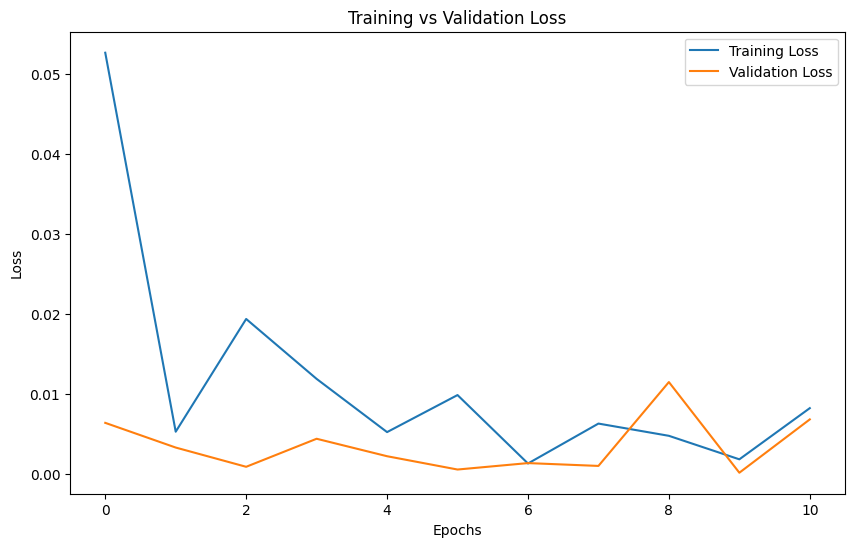

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = models.efficientnet_b0(pretrained=True)


num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)  

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

num_epochs = 100
best_val_acc = 0.0
patience_counter = 0
patience_limit = 10


best_model_wts = copy.deepcopy(model.state_dict())

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_loss = running_val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Loss: {train_loss:.4f}, '
          f'Training Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.2f}%')

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_model_wts = copy.deepcopy(model.state_dict())
        patience_counter = 0  
    else:
        patience_counter += 1

    scheduler.step(val_loss)

    if patience_counter >= patience_limit:
        print("Early stopping triggered")
        break

model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), 'best_model.pth')
print(f'Best Validation Accuracy: {best_val_acc:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()



In [52]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 99.40%


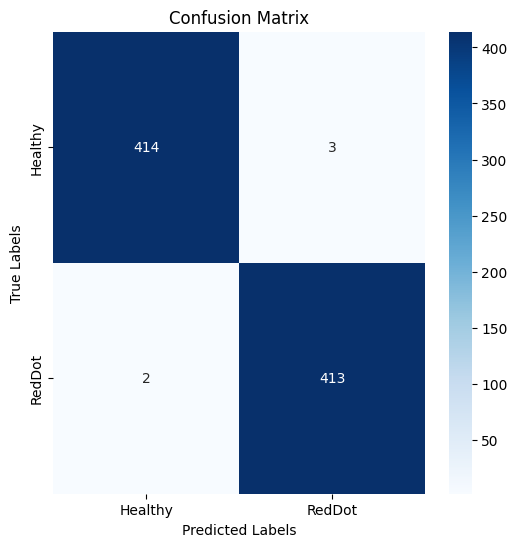

In [43]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        images, labels = batch[0], batch[1]  
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'RedDot'], yticklabels=['Healthy', 'RedDot'])
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

In [44]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
precision = precision_score(y_true, y_pred, pos_label=1) * 100
recall = recall_score(y_true, y_pred, pos_label=1) * 100
f1 = f1_score(y_true, y_pred, pos_label=1) * 100

print(f'Precision: {precision:.2f}%')
print(f'Recall: {recall:.2f}%')
print(f'F1 Score: {f1:.2f}%')

Precision: 99.28%
Recall: 99.52%
F1 Score: 99.40%


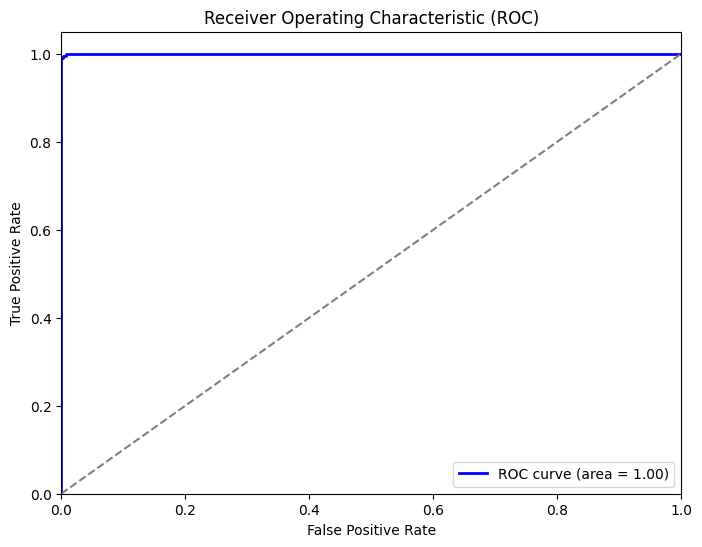

In [51]:
y_true = []
y_probs = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        y_probs.extend(probabilities)
        y_true.extend(labels.cpu().numpy())
fpr, tpr, _ = roc_curve(y_true, y_probs, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [12]:
torch.save(model.state_dict(), 'efficientnet_reddot_detection.pth')